In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA

from qiskit import(
    QuantumCircuit,
    ClassicalRegister, 
    QuantumRegister,
    transpile)

from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import efficient_su2

from qiskit.providers.basic_provider import BasicProvider
# from qiskit_ionq import IonQProvider, GPIGate, GPI2Gate, ZZGate

backend = BasicProvider().get_backend('basic_simulator')
# provider = IonQProvider()

# backend_native = provider.get_backend("simulator", gateset='native')

from givens_angles import *

In [2]:
x = np.array([[0, 1], [1, 0]], dtype='complex')
y = np.array([[0, -1j], [1j, 0]], dtype='complex')
Id = np.identity(2)
op = np.kron(Id, x) @ np.kron(y, Id) - np.kron(Id, y) @ np.kron(x, Id)

def givens_circ(theta):
    mat = LA.expm(1j/2 * theta * op)
    qreg = QuantumRegister(2)
    circ = QuantumCircuit(2)
    circ.append(UnitaryGate(mat), [0, 1])
    return circ

In [108]:
N_s = 8
N_t = 60
J = 1
h = 1
g = 0
dt = 0.1
N_t * dt

6.0

In [109]:
def build_op(N_s, site, op):
    Op = np.identity(1)
    for s in range(N_s):
        if s == site:
            Op = np.kron(Op, op)
        else:
            Op = np.kron(Op, np.identity(2))
    return Op

x = np.array([[0, 1], [1, 0]])
z = np.array([[1, 0], [0, -1]])

X = []
Z = []

for s in range(N_s):
    X.append(build_op(N_s, s, x))
    Z.append(build_op(N_s, s, z))

Ham = np.zeros((2**N_s, 2**N_s))
for i in range(N_s):
    Ham -= J * X[i] @ X[(i + 1) % N_s]
    Ham -= h * Z[i]
    Ham -= g * Z[i] @ Z[(i + 1) % N_s]

Evals, Evecs = np.linalg.eigh(Ham)
ground_state = Evecs[:, 0]

In [110]:
n_k = 3
sigma = 3/2
# Finds Givens Angles for givens N_s, n_s (if localized),
# mean position x, mean momentum number (integer), and width.
# From givens_angles.py
r = [-1, 0, 1, 2]
betas_r, angles_r = giv_angles(N_s, 4, 1, n_k, sigma, r=r)
betas_l, angles_l = giv_angles(N_s, 4, 5, -n_k, sigma, r=r)

[ 1.00000000e+00-3.88907803e-17j  5.55111512e-17-2.07823299e-17j
 -5.55111512e-17-6.65005629e-17j -1.38777878e-17+2.39730678e-17j]
[ 1.00000000e+00+4.38777748e-17j  5.55111512e-17+2.34472640e-17j
 -1.11022302e-16-2.54210201e-17j -2.77555756e-17+2.39252837e-17j]


In [111]:
vqe_angles = np.load('vqe-thetas-N8-J1-h1-g0.npy')

In [112]:
def make_circuit(t_step):
    qreg = QuantumRegister(N_s+4)
    creg = ClassicalRegister(N_s+4)
    circ = QuantumCircuit(qreg, creg)

    # State-Prep
    ## Ground state preparation
    circ.prepare_state(ground_state, range(N_s))
    # for i in range(N_s):
    #     circ.ry(vqe_angles[i], i)
    #     circ.rz(vqe_angles[N_s + i], i)

    # for i in range(2, len(vqe_angles)//N_s-1,2):    
    #     for j in range(N_s-1):
    #         k = N_s - 1 - j
    #         circ.cx(k-1, k)
    #     for j in range(N_s):
    #         circ.ry(vqe_angles[i * N_s + j], j)
    #         circ.rz(vqe_angles[(i+1) * N_s + j], j)

    ## Right moving wave packet
    ### V^dag
    for i in range(N_s//2):
        circ.rz(betas_r[i], i)
    for i in range(N_s//2-1):
        j = N_s//2 - 1 - i
        circ.append(givens_circ(angles_r[i]), [j-1, j])
    ###
    circ.x(N_s) # Prepare control
    circ.ccx(N_s, 0, N_s+1) # Remove |1> part of system qubit
    circ.x(0) # Excite system qubit
    ### V
    for i in range(N_s//2-1):
        j = N_s//2 - 2 - i
        circ.append(givens_circ(-angles_r[j]), [i, i+1])
    for i in range(N_s//2):
        circ.rz(-betas_r[i], i)
    
    # ## Left Moving Wave Packet
    # # V^dag
    for i in range(N_s//2):
        circ.rz(betas_l[i], i+N_s//2)
    for i in range(N_s//2-1):
        j = N_s//2 + i
        circ.append(givens_circ(angles_l[i]), [j, j+1])
    ###
    circ.x(N_s+2) # Prepare control
    circ.ccx(N_s+2, N_s//2, N_s+3) # Remove |1> part of system qubit
    for i in range(N_s//2): # Obey anticommutation relations
        # circ.cz(N_s+2, i)
        circ.z(i)
    # circ.cx(N_s+2, N_s//2)
    circ.x(N_s//2) # Excite system qubit
    ### V
    for i in range(N_s//2-1):
        j = N_s//2 - 2 - i
        circ.append(givens_circ(-angles_l[j]), [i+N_s//2, i+N_s//2+1])
    for i in range(N_s//2):
        circ.rz(-betas_l[i], i+N_s//2)
    
    # Trotter Evolution
    for i in range(t_step):
        # Transverse Field
        for j in range(N_s):
            circ.rz(-2 * h * dt, j)
        # Nearest-neighbor
        for j in range(N_s):
            circ.rxx(-2 * J * dt, j, (j + 1) % N_s)
        # Longitudinal Field
        for j in range(N_s):
            circ.rzz(-2 * g * dt, j, (j + 1) % N_s)
    
    # Measure
    circ.measure(qreg, creg[::-1])

    # new_circuit = transpile(circ, backend, 
    #                     basis_gates=['cx', 'id', 'rz', 'x', 'sx'], 
    #                     optimization_level=3)

    return circ

In [113]:
basis_gates = ['cz', 'rx', 'rz', 'rzz', 'sx', 'x']

circuits = []
gates = []
depths = []
for i in range(N_t):
    circuit = make_circuit(i)
    new_circuit = transpile(circuit, backend=backend, basis_gates=basis_gates)
    circuits.append(new_circuit)
    gates.append(dict(new_circuit.count_ops()))
    depths.append(new_circuit.depth())
    

In [114]:
num_shots = 100000
job = backend.run(circuits, shots=num_shots)
counts_list = job.result().get_counts()

In [115]:
# filename = 'qsim-free-Ns' + str(N_s)
# # filename = 'ionq-run-Feb10-Ns' + str(N_s)
# filename += '-lam' + str(lam)
# filename += '-eps' + str(hL)
# filename += '-dt' + str(dt)
# filename += '-shots' + str(num_shots)
# filename += '.json'

# import json
# with open(filename, 'w') as fout:
#     json.dump(counts_list, fout)

In [116]:
qc_occ_nums = []
for i in range(N_t):
    expecz = np.zeros(N_s)
    for key in counts_list[i]:
        if key[N_s+1] == '0' and key[N_s+3] == '0':
            for j in range(N_s):
                if key[j] == '0':
                    expecz[j] += counts_list[i][key] / num_shots
                else:
                    expecz[j] -= counts_list[i][key] / num_shots
    qc_occ_nums.append((1 - expecz) / 2)
qc_occ_nums = np.array(qc_occ_nums)

Text(0.5, 1.0, '(a) Initial State')

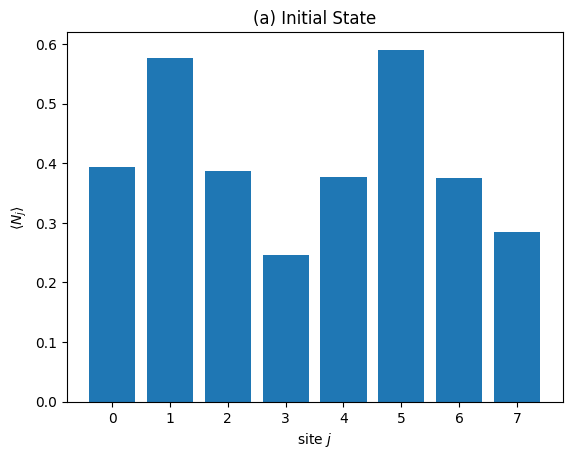

In [117]:
plt.bar(range(N_s), qc_occ_nums[0])
plt.xlabel(r'site $j$')
plt.ylabel(r'$\langle N_j \rangle$')
plt.title("(a) Initial State")

In [88]:
np.sum(qc_occ_nums[0])

np.float64(2.73546)

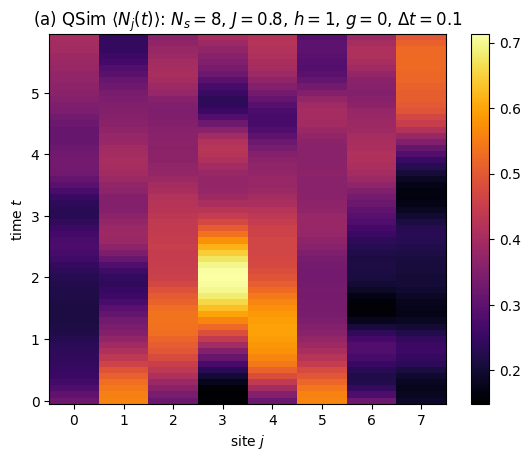

In [89]:
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

plt.pcolormesh(X, Y, qc_occ_nums, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(a) QSim $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $J = $' + str(J)
title += r', $h = $' + str(h)
title += r', $g = $' + str(g)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')

In [90]:
# for i in range(N_t):
#     plt.bar(range(N_s), qc_occ_nums[i], label='Exact Trotter', color='gray')
#     plt.xlabel('s (site)')
#     plt.ylabel(r'$\langle n_s \rangle$')
#     plt.legend()
#     plt.ylim(0,1.3)
#     title = r'$N_s =$' + str(N_s)
#     title += r', $\lambda$ = ' + str(lam)
#     title += r', $t = $' + str(round(i * dt, 4))
#     plt.title(title)
#     folder = 'qc-scattering-plots/'
#     filename = folder
#     filename += 'scatt-timestep' + str(i) + '.png'
#     plt.savefig(filename)
#     plt.close()

# Exact Diagonalization

In [91]:
def build_op(N_s, site, op):
    Op = np.identity(1, dtype='complex')
    for s in range(N_s):
        if s == site:
            Op = np.kron(op, Op)
        else:
            Op = np.kron(np.identity(2, dtype='complex'), Op)
    return Op

In [92]:
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])
n = np.array([[0, 0], [0, 1]])
sm = (x - 1j * y) / 2

X = []
Z = []
N = []
Sm = []

for i in range(N_s):
    X.append(build_op(N_s, i, x))
    Z.append(build_op(N_s, i, z))
    N.append(build_op(N_s, i, n))
    Sm.append(build_op(N_s, i, sm))

H_XX = np.zeros((2**N_s, 2**N_s), dtype=complex)
H_Z = np.zeros((2**N_s, 2**N_s), dtype=complex)
H_ZZ = np.zeros((2**N_s, 2**N_s), dtype=complex)

for j in range(N_s):
    H_XX -= J * X[j] @ X[(j + 1) % N_s]
    H_Z -= h * Z[j]
    H_ZZ -= g * Z[j] @ Z[(j + 1) % N_s]

TEO = LA.expm(-1j * dt * H_Z) @ LA.expm(-1j * dt * H_XX) @ LA.expm(-1j * dt * H_ZZ)

H = H_XX + H_Z + H_ZZ
Evals, Evecs = np.linalg.eigh(H)
ground_state = Evecs[:,0]

In [93]:
CDAG = []
for s in range(N_s):
    cdag = Sm[s]
    for j in range(s):
        cdag = -Z[j] @ cdag
    CDAG.append(cdag)

In [94]:
x = [-1, 0, 1, 2]
def GWP_coeff(x, x_mean, x_dif, nk_mean, sig_k):
    k = nk_mean * np.pi / N_s
    coeff = 1 / np.sqrt(N_s) * np.exp(-1j * k * (x + x_mean))
    coeff *= np.exp(-x_dif[x]**2 / sig_k**2)
    return coeff

In [95]:
xr_mean = 1
xl_mean = 5
nk_mean = 3
sig_k = 3/2
nks = np.arange(-N_s + 1, N_s + 1, 2)
rm_op = np.zeros((2**N_s, 2**N_s), dtype=complex)
lm_op = np.zeros((2**N_s, 2**N_s), dtype=complex)
for j in range(4):
    rm_op += GWP_coeff(j, 1, x, nk_mean, sig_k) * CDAG[j]
    lm_op += GWP_coeff(j, 5, x, -nk_mean, sig_k) * CDAG[j + 4]

exact_init_state = np.zeros((2**N_s), dtype=complex)
exact_init_state[0] = 1
exact_init_state = lm_op @ rm_op @ ground_state
exact_init_state /= np.linalg.norm(exact_init_state)

In [96]:
state = np.array(exact_init_state)
occs = []
for t in range(N_t):
    occ = []
    for j in range(N_s):
        occ_j = np.inner(state.conjugate(), N[j] @ state)
        occ.append(occ_j)
    occs.append(np.real(occ))
    state = TEO @ state

Text(0.5, 1.0, 'Initial State: $N_s = $8, $n_k = \\pm$3, $\\sigma_k=$1.5')

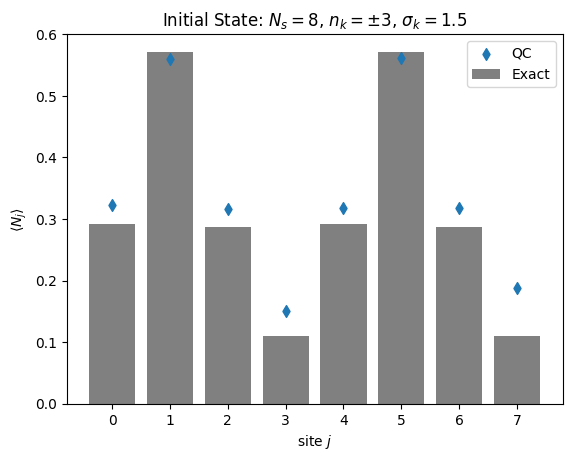

In [97]:
plt.bar(range(N_s), occs[0], color='grey', label='Exact')
plt.scatter(range(N_s), qc_occ_nums[0], marker='d', label='QC')
plt.legend()
plt.xlabel(r'site $j$')
plt.ylabel(r'$\langle N_j \rangle$')
title = r'Initial State: '
title += r'$N_s = $' + str(N_s)
title += r', $n_k = \pm$' + str(nk_mean)
title += r', $\sigma_k=$' + str(sig_k)
plt.title(title)

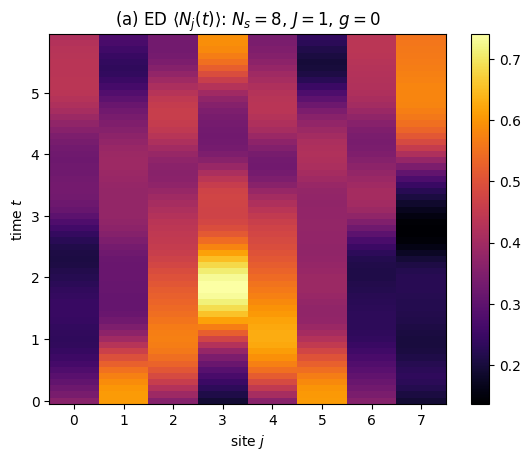

In [62]:
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

plt.pcolormesh(X, Y, occs, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(a) ED $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $J = $' + str(J)
# title += r', $h = $' + str(h)
title += r', $g = $' + str(g)
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')

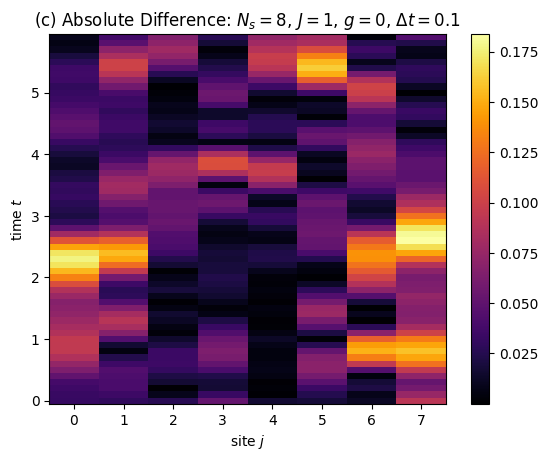

In [63]:
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

perc_errors = []
for t in range(N_t):
    perc_error_t = []
    for j in range(N_s):
        perc_error = np.abs(occs[t][j] - qc_occ_nums[t][j])
        perc_error_t.append(perc_error)
    perc_errors.append(perc_error_t)

plt.pcolormesh(X, Y, perc_errors, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(c) Absolute Difference: $N_s = $' + str(N_s)
title += r', $J = $' + str(J)
# title += r', $h = $' + str(h)
title += r', $g = $' + str(g)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')